In [1]:
import tensorflow as tf
import torch
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib


/Users/hendrik/MRI-Super-Resolution/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
class LinearNoiseScheduler:
    r"""
    Class for the linear noise scheduler that is used in DDPM.
    """
    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1. - self.betas
        self.alpha_cum_prod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_cum_prod = torch.sqrt(self.alpha_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alpha_cum_prod)
        
    def add_noise(self, original, noise, t):
        r"""
        Forward method for diffusion
        :param original: Image on which noise is to be applied
        :param noise: Random Noise Tensor (from normal dist)
        :param t: timestep of the forward process of shape -> (B,)
        :return:
        """
        original_shape = original.shape
        batch_size = original_shape[0]
        
        sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod.to(original.device)[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod.to(original.device)[t].reshape(batch_size)
        
        # Reshape till (B,) becomes (B,1,1,1) if image is (B,C,H,W)
        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
        for _ in range(len(original_shape) - 1):
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)
        
        # Apply and Return Forward process equation
        return (sqrt_alpha_cum_prod.to(original.device) * original
                + sqrt_one_minus_alpha_cum_prod.to(original.device) * noise)
        
    def sample_prev_timestep(self, xt, noise_pred, t):
        r"""
            Use the noise prediction by model to get
            xt-1 using xt and the noise predicted
        :param xt: current timestep sample
        :param noise_pred: model noise prediction
        :param t: current timestep we are at
        :return:
        """
        x0 = ((xt - (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t] * noise_pred)) /
              torch.sqrt(self.alpha_cum_prod.to(xt.device)[t]))
        x0 = torch.clamp(x0, -1., 1.)
        
        mean = xt - ((self.betas.to(xt.device)[t]) * noise_pred) / (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t])
        mean = mean / torch.sqrt(self.alphas.to(xt.device)[t])
        
        if t == 0:
            return mean, x0
        else:
            variance = (1 - self.alpha_cum_prod.to(xt.device)[t - 1]) / (1.0 - self.alpha_cum_prod.to(xt.device)[t])
            variance = variance * self.betas.to(xt.device)[t]
            sigma = variance ** 0.5
            z = torch.randn(xt.shape).to(xt.device)
            
            # OR
            # variance = self.betas[t]
            # sigma = variance ** 0.5
            # z = torch.randn(xt.shape).to(xt.device)
            return mean + sigma * z, x0

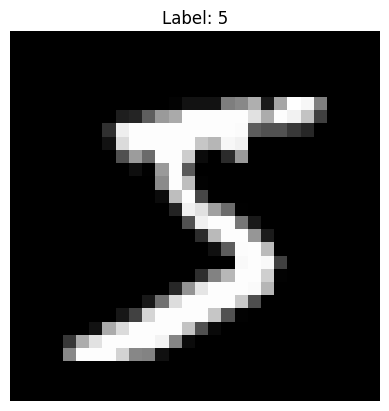

In [7]:

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Select the first image
first_image = x_train[0]

# Display the first image
plt.imshow(first_image, cmap='gray')
plt.title(f"Label: {y_train[0]}")
plt.axis('off')
plt.show()

In [8]:
type(y_train[0])

numpy.uint8

Initial Image - Step 0, Top-Left Pixel Value: -1.0000
Step 1 - Noisy Image, Top-Left Pixel Value: -0.8394
Step 1 - Added Noise, Top-Left Pixel Value: 0.0550
Step 2 - Noisy Image, Top-Left Pixel Value: -0.6805
Step 2 - Added Noise, Top-Left Pixel Value: 0.0703
Step 3 - Noisy Image, Top-Left Pixel Value: -0.5885
Step 3 - Added Noise, Top-Left Pixel Value: 0.0202
Step 4 - Noisy Image, Top-Left Pixel Value: -0.5129
Step 4 - Added Noise, Top-Left Pixel Value: 0.0135
Step 5 - Noisy Image, Top-Left Pixel Value: -0.3637
Step 5 - Added Noise, Top-Left Pixel Value: 0.0950
Step 6 - Noisy Image, Top-Left Pixel Value: -0.3216
Step 6 - Added Noise, Top-Left Pixel Value: 0.0037
Step 7 - Noisy Image, Top-Left Pixel Value: -0.2599
Step 7 - Added Noise, Top-Left Pixel Value: 0.0277
Step 8 - Noisy Image, Top-Left Pixel Value: -0.2696
Step 8 - Added Noise, Top-Left Pixel Value: -0.0372
Step 9 - Noisy Image, Top-Left Pixel Value: -0.2360
Step 9 - Added Noise, Top-Left Pixel Value: 0.0052
Step 10 - Noisy Im

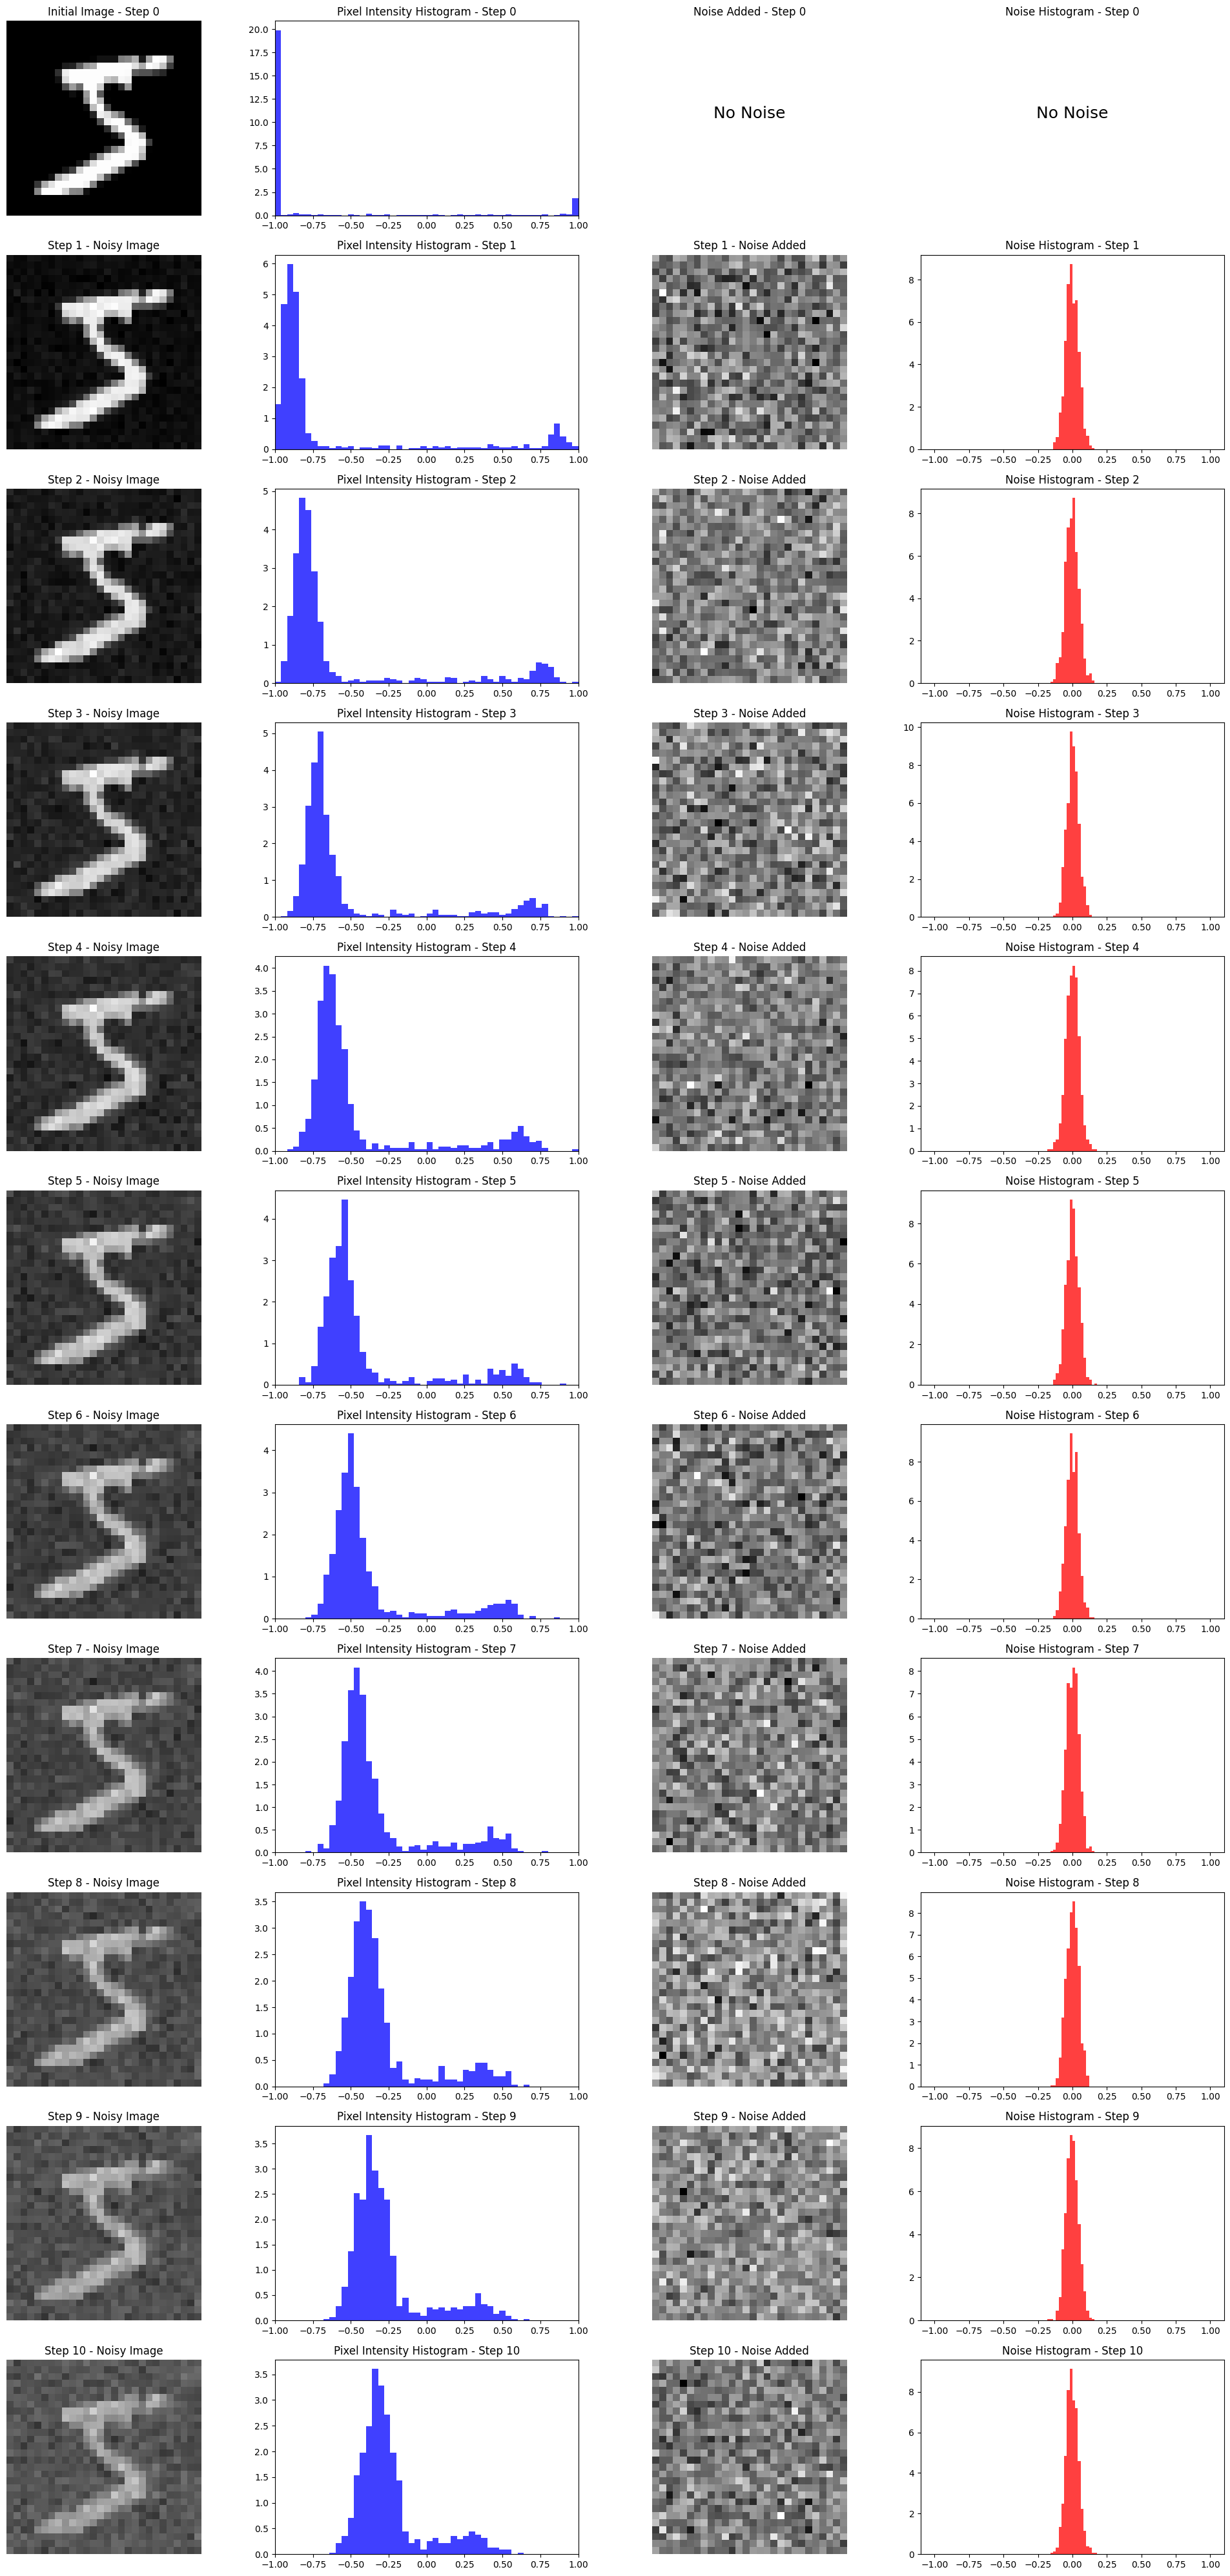

In [37]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Select the first image and normalize it to [0, 1]
image = (x_train[0] / 255.0) * 2 - 1

nifti_file = '../data/HCP/Structural Preprocessed for 7T (1.6mm:59k mesh)/100610/MNINonLinear/T1w_restore.1.60.nii'
# img = nib.load(nifti_file)
# data1 = img.get_fdata()
# slice_index = data1.shape[2] // 2  # Taking the middle slice along the z-axis
# image = data1[:, :, slice_index] 


# Define alpha and beta# scaling factor
beta = 0.2  # noise scaling factor
alpha = np.sqrt(1-beta)
beta = np.sqrt(beta)

# Initialize x_t with the original image
x_t = image

# Number of steps
num_steps = 10

# Plotting the initial image, the progression of noise addition, noise maps, and noise histograms
fig, axes = plt.subplots(num_steps + 1, 4, figsize=(20, 4 * num_steps))

# Print the top-left pixel value of the initial image
print(f"Initial Image - Step 0, Top-Left Pixel Value: {image[0, 0]:.4f}")

# Plot the initial image
axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title('Initial Image - Step 0')
axes[0, 0].axis('off')

# Plot the histogram of pixel intensities for the initial image
axes[0, 1].hist(image.flatten(), bins=50, range=(-1, 1), density=True, alpha=0.75, color='blue')
axes[0, 1].set_xlim([-1, 1])
axes[0, 1].set_title('Pixel Intensity Histogram - Step 0')

# No noise added for the initial image
axes[0, 2].text(0.5, 0.5, 'No Noise', fontsize=18, ha='center')
axes[0, 2].set_title('Noise Added - Step 0')
axes[0, 2].axis('off')

# No noise histogram for the initial image
axes[0, 3].text(0.5, 0.5, 'No Noise', fontsize=18, ha='center')
axes[0, 3].set_title('Noise Histogram - Step 0')
axes[0, 3].axis('off')

for t in range(1, num_steps + 1):
    # Generate Gaussian noise with mean 0.5 and standard deviation 0.1
    noise = np.random.normal(0, 0.1, image.shape)
    
    # Update x_t using the equation
    x_t = x_t * alpha + beta * noise

    
    # Print the top-left pixel values for the noisy image and the added noise
    print(f"Step {t} - Noisy Image, Top-Left Pixel Value: {x_t[0, 0]:.4f}")
    print(f"Step {t} - Added Noise, Top-Left Pixel Value: {(beta * noise)[0, 0]:.4f}")
    
    # Plot the image at step t
    axes[t, 0].imshow(x_t, cmap='gray', vmin=-1, vmax=1)
    axes[t, 0].set_title(f'Step {t} - Noisy Image')
    axes[t, 0].axis('off')

    
    # Plot the histogram of pixel intensities
    axes[t, 1].hist(x_t.flatten(), bins=50, range=(-1, 1), density=True, alpha=0.75, color='blue')
    axes[t, 1].set_xlim([-1, 1])
    axes[t, 1].set_title(f'Pixel Intensity Histogram - Step {t}')
    
    # Plot the noise map
    axes[t, 2].imshow(beta * noise, cmap='gray')
    axes[t, 2].set_title(f'Step {t} - Noise Added')
    axes[t, 2].axis('off')

    # Plot the histogram of the noise
    axes[t, 3].hist((noise).flatten() * beta, bins=100, density=True, alpha=0.75, color='red', range=(-1, 1))
    axes[t, 3].set_title(f'Noise Histogram - Step {t}')

plt.tight_layout()
plt.show()

Initial Image - Step 0, Top-Left Pixel Value: -1.0000
Step 1 - Noisy Image, Top-Left Pixel Value: -0.9987
Step 1 - Added Noise, Top-Left Pixel Value: 0.0008
Step 2 - Noisy Image, Top-Left Pixel Value: -1.0005
Step 2 - Added Noise, Top-Left Pixel Value: -0.0535
Step 3 - Noisy Image, Top-Left Pixel Value: -0.8319
Step 3 - Added Noise, Top-Left Pixel Value: 0.0625
Step 4 - Noisy Image, Top-Left Pixel Value: -0.7285
Step 4 - Added Noise, Top-Left Pixel Value: -0.0329
Step 5 - Noisy Image, Top-Left Pixel Value: -0.3092
Step 5 - Added Noise, Top-Left Pixel Value: 0.2548
Step 6 - Noisy Image, Top-Left Pixel Value: -0.1233
Step 6 - Added Noise, Top-Left Pixel Value: 0.0952
Step 7 - Noisy Image, Top-Left Pixel Value: -0.0676
Step 7 - Added Noise, Top-Left Pixel Value: 0.0104
Step 8 - Noisy Image, Top-Left Pixel Value: 0.1722
Step 8 - Added Noise, Top-Left Pixel Value: 0.2092
Step 9 - Noisy Image, Top-Left Pixel Value: -0.2378
Step 9 - Added Noise, Top-Left Pixel Value: -0.3148
Step 10 - Noisy I

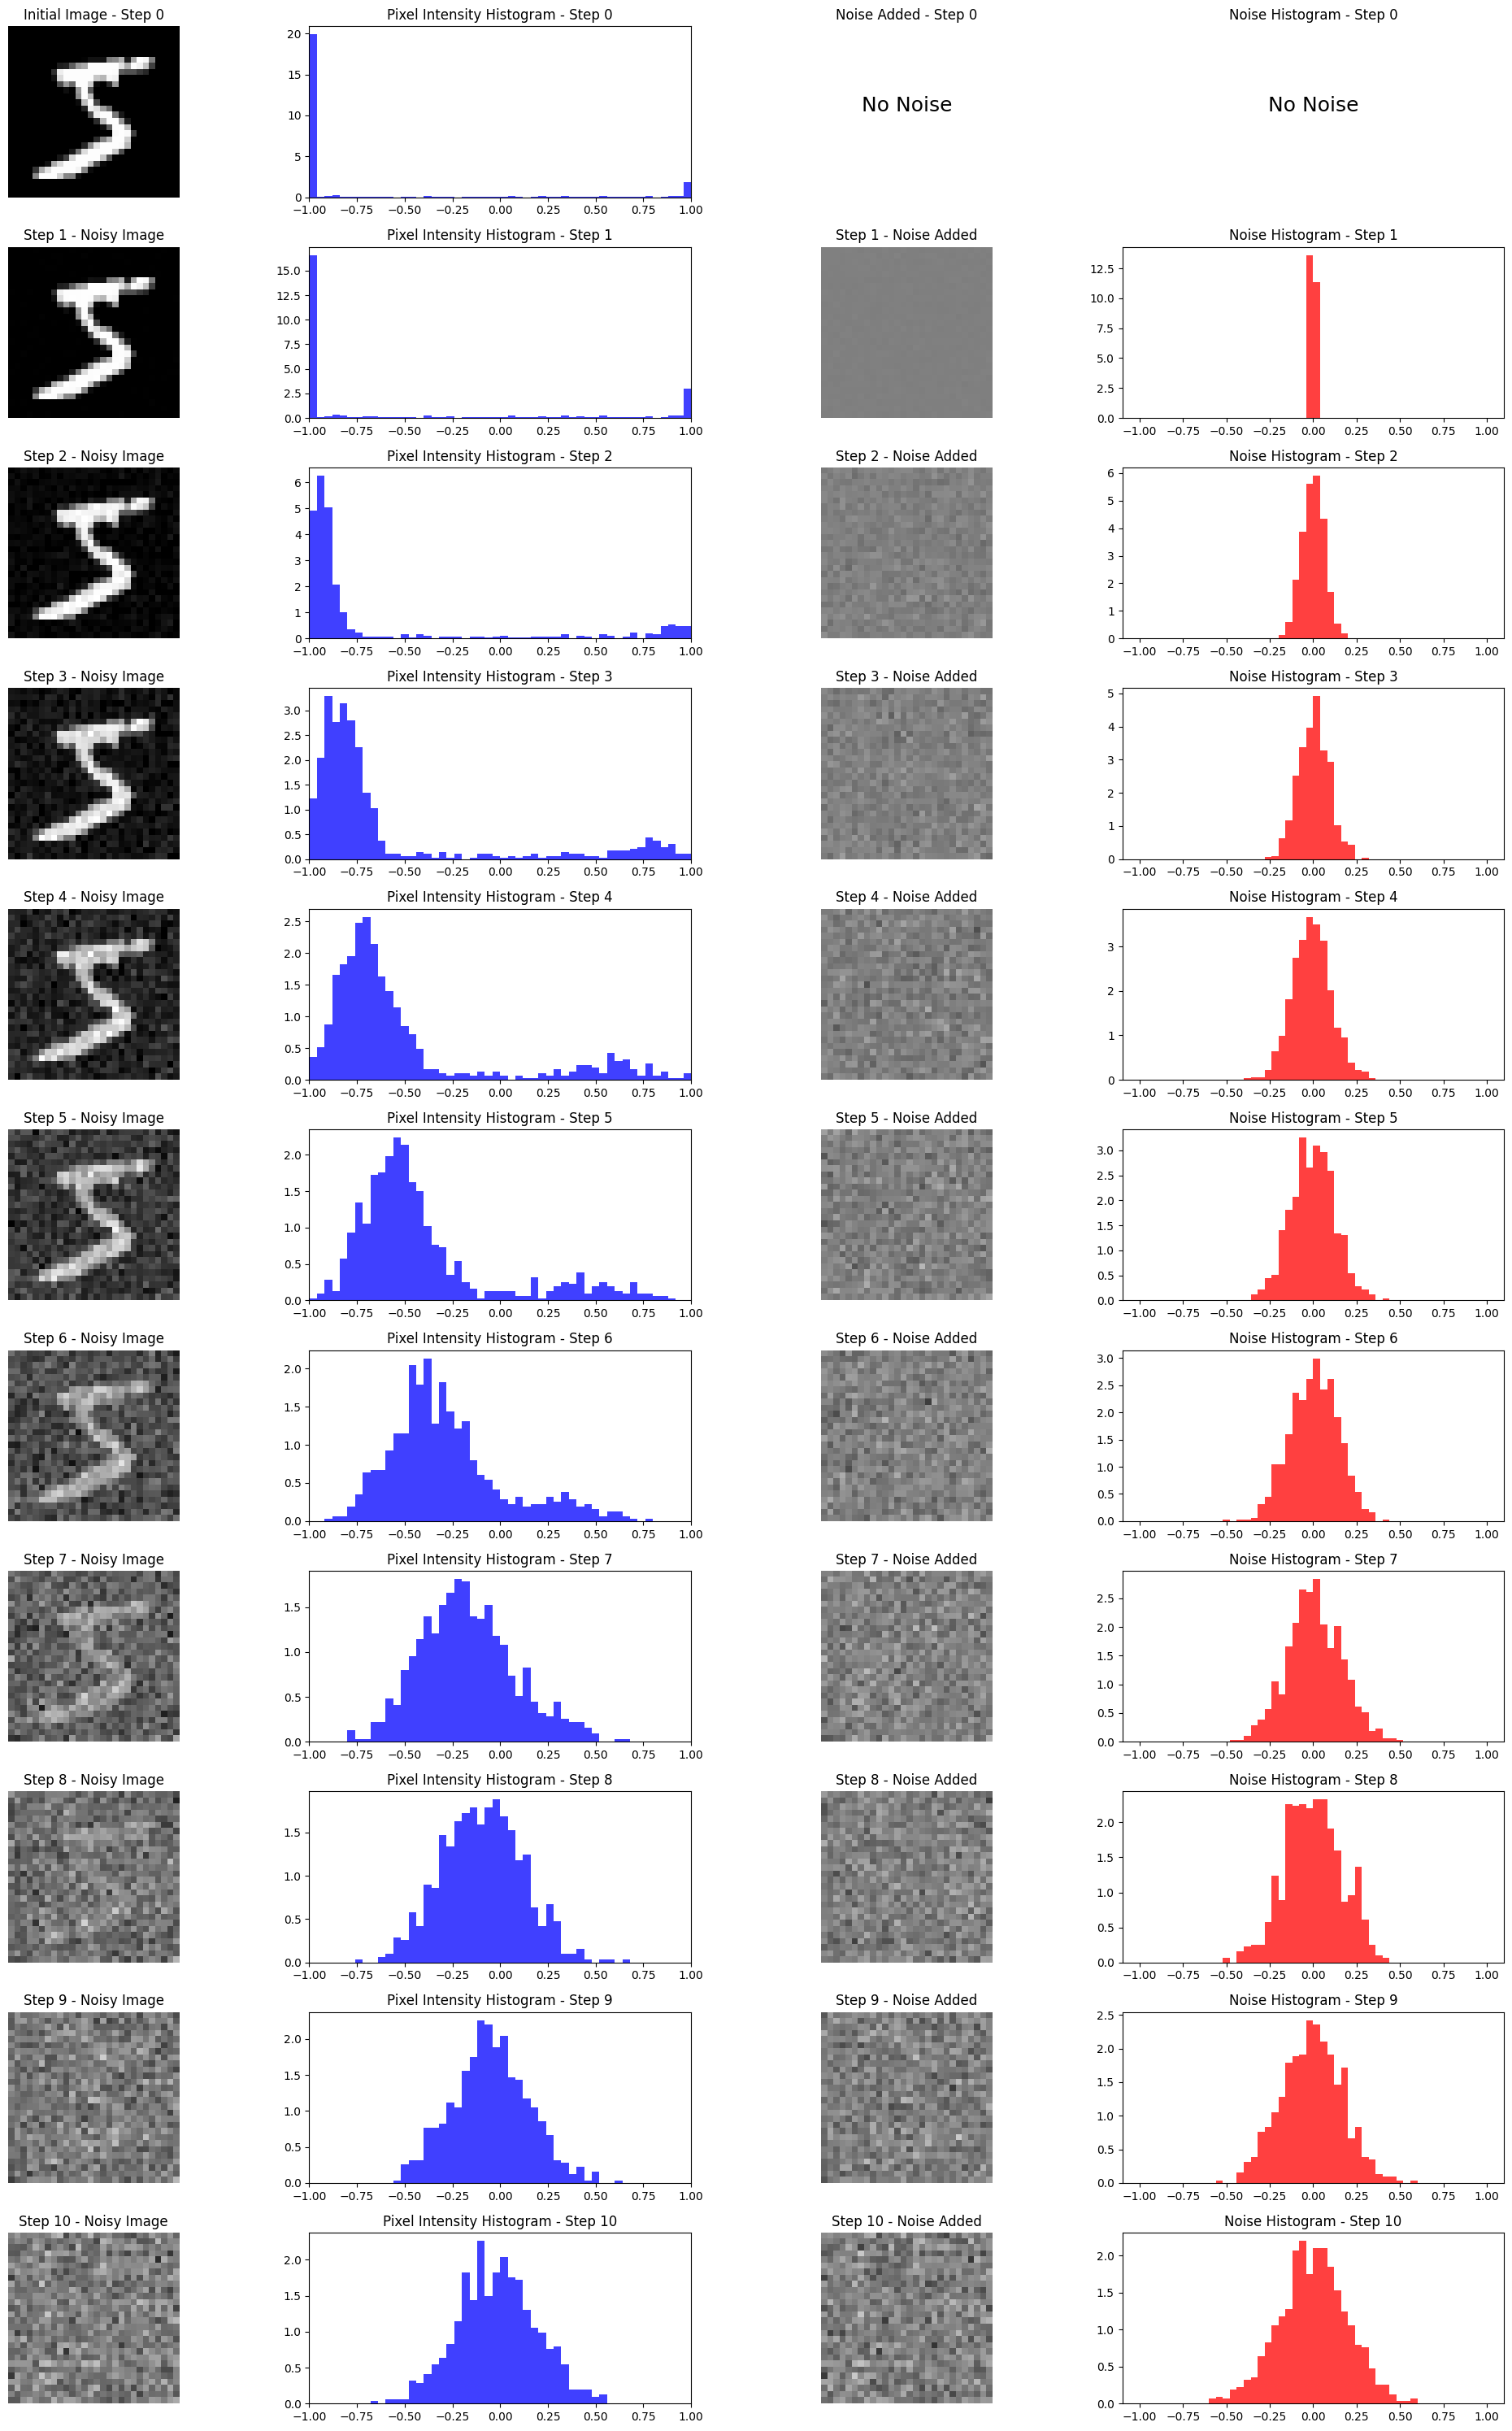

In [38]:

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Select the first image and normalize it to [-1, 1]
image = (x_train[0] / 255.0) * 2 - 1

# Number of steps
num_steps = 10

# Define the linear scheduler for beta
beta_min = 0.001
beta_max = 0.4
betas = np.linspace(beta_min, beta_max, num_steps)

# Initialize x_t with the original image
x_t = image

# Plotting the initial image, the progression of noise addition, noise maps, and noise histograms
fig, axes = plt.subplots(num_steps + 1, 4, figsize=(20, 3 * num_steps))

# Print the top-left pixel value of the initial image
print(f"Initial Image - Step 0, Top-Left Pixel Value: {image[0, 0]:.4f}")

# Plot the initial image
axes[0, 0].imshow(image, cmap='gray', vmin=-1, vmax=1)
axes[0, 0].set_title('Initial Image - Step 0')
axes[0, 0].axis('off')

# Plot the histogram of pixel intensities for the initial image
axes[0, 1].hist(image.flatten(), bins=50, range=(-1, 1), density=True, alpha=0.75, color='blue')
axes[0, 1].set_xlim([-1, 1])
axes[0, 1].set_title('Pixel Intensity Histogram - Step 0')

# No noise added for the initial image
axes[0, 2].text(0.5, 0.5, 'No Noise', fontsize=18, ha='center')
axes[0, 2].set_title('Noise Added - Step 0')
axes[0, 2].axis('off')

# No noise histogram for the initial image
axes[0, 3].text(0.5, 0.5, 'No Noise', fontsize=18, ha='center')
axes[0, 3].set_title('Noise Histogram - Step 0')
axes[0, 3].axis('off')

for t in range(1, num_steps + 1):
    # Set alpha and beta for the current step
    beta_t = betas[t - 1]
    alpha = np.sqrt(1 - beta_t)
    beta = np.sqrt(beta_t)
    
    # Generate Gaussian noise with mean 0 and standard deviation 1
    noise = np.random.normal(0, 0.2, image.shape)
    
    # Update x_t using the equation
    x_t = x_t * alpha + beta * noise
    
    # Print the top-left pixel values for the noisy image and the added noise
    print(f"Step {t} - Noisy Image, Top-Left Pixel Value: {x_t[0, 0]:.4f}")
    print(f"Step {t} - Added Noise, Top-Left Pixel Value: {(beta * noise)[0, 0]:.4f}")
    
    # Plot the image at step t
    axes[t, 0].imshow(x_t, cmap='gray', vmin=-1, vmax=1)
    axes[t, 0].set_title(f'Step {t} - Noisy Image')
    axes[t, 0].axis('off')
    
    # Plot the histogram of pixel intensities
    axes[t, 1].hist(x_t.flatten(), bins=50, range=(-1, 1), density=True, alpha=0.75, color='blue')
    axes[t, 1].set_xlim([-1, 1])
    axes[t, 1].set_title(f'Pixel Intensity Histogram - Step {t}')
    
    # Plot the noise map
    axes[t, 2].imshow(noise * beta, cmap='gray', vmin=-1, vmax=1)
    axes[t, 2].set_title(f'Step {t} - Noise Added')
    axes[t, 2].axis('off')

    # Plot the histogram of the noise
    axes[t, 3].hist((noise).flatten() * beta , bins=50, density=True, alpha=0.75, color='red', range=(-1, 1))
    axes[t, 3].set_title(f'Noise Histogram - Step {t}')

plt.tight_layout()
plt.show()

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

# Define the U-Net model architecture
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Downsampling path
        self.down1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.down4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        # Upsampling path
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.up4 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # Downsampling path
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)

        # Upsampling path
        x = self.up1(x4)

        # Skip connections
        x3_resized = F.interpolate(x3, size=x.shape[2:])
        x = self.up2(x + x3_resized)

        x2_resized = F.interpolate(x2, size=x.shape[2:])
        x = self.up3(x + x2_resized)

        x1_resized = F.interpolate(x1, size=x.shape[2:])
        x = self.up4(x + x1_resized)

        return x

# Define the diffusion model
class DiffusionModel(nn.Module):
    def __init__(self, model, T=50, beta_min=0.01, beta_max=0.1, device='mps'):
        super(DiffusionModel, self).__init__()
        self.model = model
        self.T = T
        self.device = device
        # Custom beta schedule
        self.betas = torch.linspace(beta_min, beta_max, T).to(self.device)

    def q_sample(self, x_start, t):
        noise = torch.randn_like(x_start) * sigma + mu  # Use mu and sigma for noise
        sqrt_alpha = (1 - self.betas).cumprod(dim=0)[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha = (1 - (1 - self.betas).cumprod(dim=0)[t]).view(-1, 1, 1, 1)
        return sqrt_alpha * x_start + sqrt_one_minus_alpha * noise

    def forward(self, x_start, t):
        x_t = self.q_sample(x_start, t)
        return self.model(x_t)

# Training function
def train(model, device, train_loader, optimizer, T):
    model.train()
    mse_loss = nn.MSELoss()
    for epoch in range(2):  # Train for 5 epochs
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            t = torch.randint(0, T, (data.size(0),), device=device).long()
            optimizer.zero_grad()

            noise_pred = model(data, t)

            # Resize noise_pred to match the size of data if necessary
            if noise_pred.shape != data.shape:
                noise_pred = F.interpolate(noise_pred, size=data.shape[2:])

            noise_true = torch.randn_like(data) * sigma + mu  # Use mu and sigma for noise
            loss = mse_loss(noise_pred, noise_true)
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch} [Batch: {batch_idx}/{len(train_loader)}]\tLoss: {loss.item()}')


In [62]:
# Parameters
T = 500
beta_min = 0.0001
beta_max = 0.02
mu = 0
sigma = 0.2

# Setup device and data
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Rescale images to [-1, 1]
])

train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform),
                          batch_size=256, shuffle=True)

# Initialize model and optimizer
model = DiffusionModel(UNet(), T=T, beta_min=beta_min, beta_max=beta_max, device=device).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the model
train(model, device, train_loader, optimizer, T=T)

# Save the model after training
torch.save(model.state_dict(), 'diffusion_model_mnist.pth')

Using device: mps
Epoch: 0 [Batch: 0/235]	Loss: 0.0842180997133255
Epoch: 0 [Batch: 100/235]	Loss: 0.04026131331920624
Epoch: 0 [Batch: 200/235]	Loss: 0.03997040539979935
Epoch: 1 [Batch: 0/235]	Loss: 0.040148813277482986
Epoch: 1 [Batch: 100/235]	Loss: 0.04009157419204712
Epoch: 1 [Batch: 200/235]	Loss: 0.039857182651758194


In [63]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train(model, device, train_loader, optimizer, T=T)

# Save the model after training
torch.save(model.state_dict(), 'diffusion_model_mnist.pth')

Epoch: 0 [Batch: 0/235]	Loss: 0.0401202067732811
Epoch: 0 [Batch: 100/235]	Loss: 0.03988303244113922
Epoch: 0 [Batch: 200/235]	Loss: 0.03991033136844635
Epoch: 1 [Batch: 0/235]	Loss: 0.04009271413087845
Epoch: 1 [Batch: 100/235]	Loss: 0.03976288437843323
Epoch: 1 [Batch: 200/235]	Loss: 0.040072109550237656


/var/folders/1g/rwnkwjjs0w9_xcc0cwsf40dw0000gn/T/ipykernel_21591/2178303941.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('diffusion_m

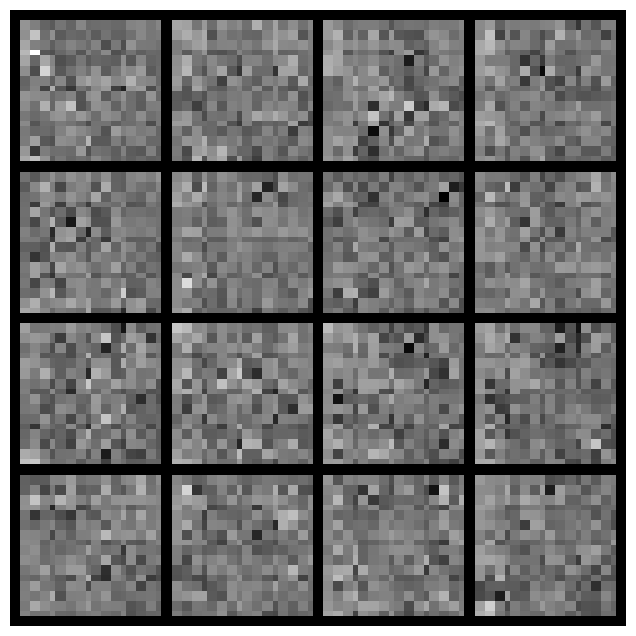

In [64]:
import matplotlib.pyplot as plt
from torchvision.utils import save_image

# Reload the model for sampling with the same parameters
model = DiffusionModel(UNet(), T=T, beta_min=beta_min, beta_max=beta_max, device=device).to(device)
model.load_state_dict(torch.load('diffusion_model_mnist.pth'))

# Sampling Loop
def sample_and_plot(model, device, num_samples=16):
    model.eval()
    with torch.no_grad():
        # Start with Gaussian noise with mean = mu and std = sigma
        x = torch.randn(num_samples, 1, 28, 28, device=device) * sigma + mu
        for t in reversed(range(model.T)):
            noise = torch.randn_like(x) * sigma + mu if t > 0 else torch.zeros_like(x)
            x_model = model.model(x)
            
            # Resize x_model to match the size of x if necessary
            if x_model.shape != x.shape:
                x_model = F.interpolate(x_model, size=x.shape[2:])
            
            x = x_model + noise
        
        # Plot the sampled images
        x = x.cpu()
        save_image(x, f'generated_samples.png', nrow=4, normalize=True)
        plt.figure(figsize=(8, 8))
        plt.imshow(plt.imread('generated_samples.png'))
        plt.axis('off')
        plt.show()

# Generate and plot samples
sample_and_plot(model, device)

/var/folders/1g/rwnkwjjs0w9_xcc0cwsf40dw0000gn/T/ipykernel_21591/900940615.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('diffusion_mo

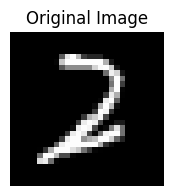

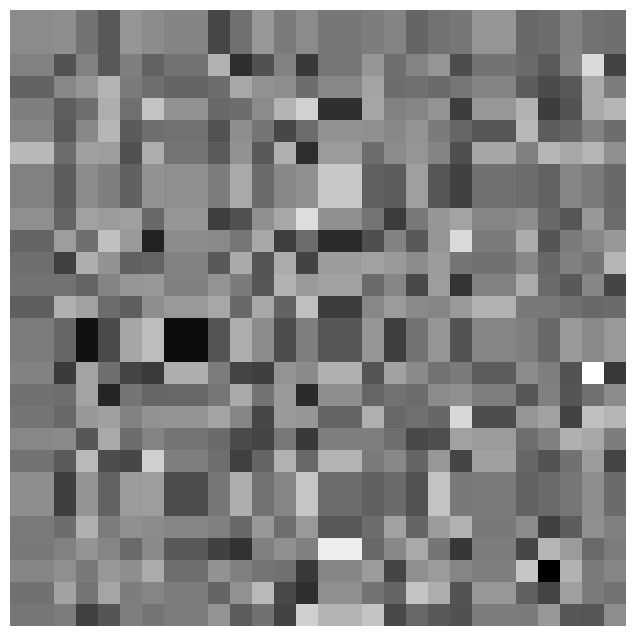

In [53]:
import matplotlib.pyplot as plt
from torchvision.utils import save_image

# Reload the model for sampling with the same parameters
model = DiffusionModel(UNet(), T=T, beta_min=beta_min, beta_max=beta_max, device=device).to(device)
model.load_state_dict(torch.load('diffusion_model_mnist.pth'))

# Sampling Loop using an image from the dataset
def sample_and_plot(model, device, data_loader, num_samples=1):
    model.eval()
    with torch.no_grad():
        # Get an image from the dataset
        data_iter = iter(data_loader)
        real_image, _ = next(data_iter)
        real_image = real_image[:num_samples].to(device)  # Select the first image and normalize it to [-1, 1]

        # Plot the original image
        plt.figure(figsize=(2, 2))
        plt.imshow(real_image[0].cpu().squeeze(), cmap='gray', vmin=-1, vmax=1)
        plt.title('Original Image')
        plt.axis('off')
        plt.show()

        # Initialize x with the real image
        x = real_image.clone()

        # Apply the diffusion process in reverse
        for t in reversed(range(model.T)):
            noise = torch.randn_like(x) * sigma + mu if t > 0 else torch.zeros_like(x)
            x_model = model.model(x)
            
            # Resize x_model to match the size of x if necessary
            if x_model.shape != x.shape:
                x_model = F.interpolate(x_model, size=x.shape[2:])
            
            x = x_model + noise
        
        # Plot the sampled images
        x = x.cpu()
        save_image(x, f'generated_samples_from_real_image.png', nrow=4, normalize=True)
        plt.figure(figsize=(8, 8))
        plt.imshow(plt.imread('generated_samples_from_real_image.png'))
        plt.axis('off')
        plt.show()

# Generate and plot samples using an image from the dataset
sample_and_plot(model, device, train_loader)

/var/folders/1g/rwnkwjjs0w9_xcc0cwsf40dw0000gn/T/ipykernel_33458/4240708861.py:106: RuntimeWarning: invalid value encountered in sqrt
  beta = np.sqrt(beta_t)
/Users/hendrik/MRI-Super-Resolution/venv/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


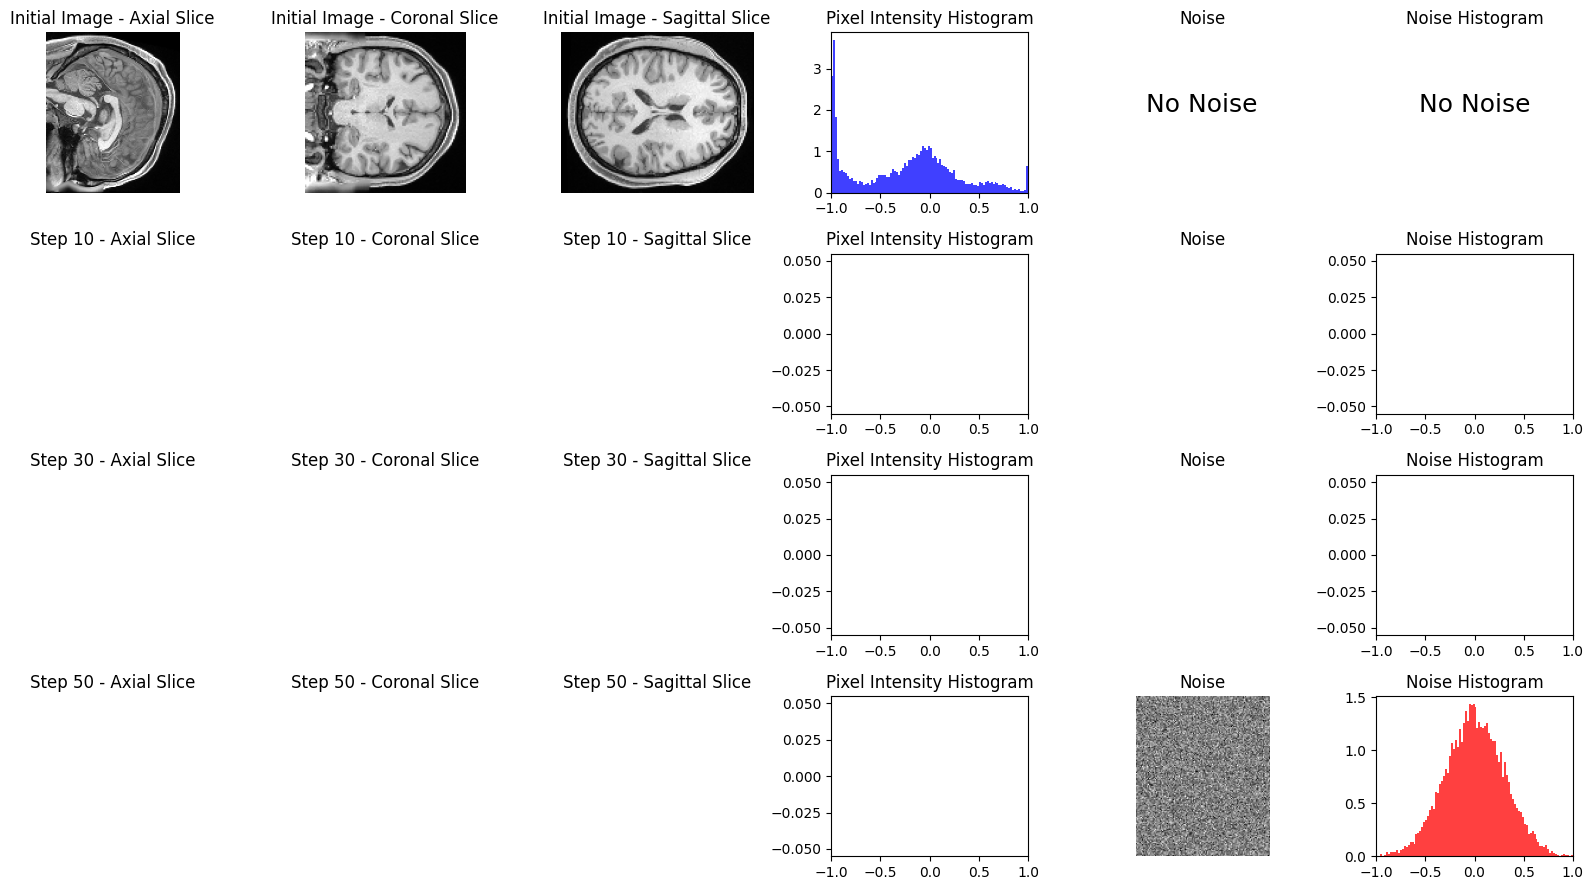

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

# Load the NIfTI file t1w
nifti_file = '../data/HCP/Structural Preprocessed for 7T (1.6mm:59k mesh)/100610/MNINonLinear/T1w_restore.1.60.nii'
img = nib.load(nifti_file)
data_cube = img.get_fdata()

def clip_intensity(data, min_percentile=1, max_percentile=99):
    # Calculate the global min and max intensity values for clipping
    min_val = np.percentile(data, min_percentile)
    max_val = np.percentile(data, max_percentile)
    # Apply clipping to the entire dataset
    clipped_data = np.clip(data, min_val, max_val)
    return clipped_data

data_cube = clip_intensity(data_cube)   

# Z normalization
def z_score_normalize(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    z_normalized_data = (data - mean) / std_dev
    return z_normalized_data

data_cube = z_score_normalize(data_cube)

# MinMax to [-1, 1]
def min_max_scale(data, new_min=-1, new_max=1):
    data_min = np.min(data)
    data_max = np.max(data)
    data_scaled = (data - data_min) / (data_max - data_min)  # Rescale to [0, 1]
    data_scaled = data_scaled * (new_max - new_min) + new_min  # Rescale to [new_min, new_max]
    return data_scaled

# Scale the initial image between -1 and 1
data_cube = min_max_scale(data_cube)

# Number of steps
num_steps = 50

# Define the cosine noise scheduler for alpha
def cosine_schedule(t, T):
    return np.cos((t / T) * np.pi / 2) ** 2

# Compute beta values based on the alpha values
alphas = 1 - betas

# Initialize x_t with the original 3D image
x_t = data_cube

# Specify the steps where you want to plot the slices, including the initial image at step 0
plot_steps = [10, 30, 50]

# Create a figure to plot the images and histograms
fig, axes = plt.subplots(len(plot_steps)+1, 6, figsize=(16, 3 * (len(plot_steps))))

# Plot the initial image (step 0) after ensuring it's scaled between -1 and 1
axes[0, 0].imshow(x_t[x_t.shape[0] // 2, :, :], cmap='gray', vmin=-1, vmax=1)
axes[0, 0].set_title('Initial Image - Axial Slice')
axes[0, 0].axis('off')

axes[0, 1].imshow(x_t[:, x_t.shape[1] // 2, :], cmap='gray', vmin=-1, vmax=1)
axes[0, 1].set_title('Initial Image - Coronal Slice')
axes[0, 1].axis('off')

axes[0, 2].imshow(x_t[:, :, x_t.shape[2] // 2], cmap='gray', vmin=-1, vmax=1)
axes[0, 2].set_title('Initial Image - Sagittal Slice')
axes[0, 2].axis('off')

# Combine the slices for histogram computation
combined_slices = np.concatenate([
    x_t[x_t.shape[0] // 2, :, :].flatten()
])

# Plot the histogram of pixel intensities for the combined slices
axes[0, 3].hist(combined_slices, bins=100, range=(-1, 1), density=True, alpha=0.75, color='blue')
axes[0, 3].set_xlim([-1, 1])
axes[0, 3].set_title('Pixel Intensity Histogram')

# No noise map for the initial image
axes[0, 4].text(0.5, 0.5, 'No Noise', fontsize=18, ha='center')
axes[0, 4].set_title('Noise')
axes[0, 4].axis('off')

# No noise histogram for the initial image
axes[0, 5].text(0.5, 0.5, 'No Noise', fontsize=18, ha='center')
axes[0, 5].set_title('Noise Histogram')
axes[0, 5].axis('off')

# Iterate through each step
for t in range(1, num_steps + 1):
    # Set alpha and beta for the current step
    beta_t = betas[t - 1]
    alpha = np.sqrt(1 - beta_t)
    beta = np.sqrt(beta_t)

    # Generate Gaussian noise with mean 0 and standard deviation 0.3
    noise = np.random.normal(0, 0.3, data_cube.shape)
    
    # Update x_t using the equation
    x_t = x_t * alpha + beta * noise
    
    # Check if the current step is one of the plot_steps
    if t in plot_steps:
        index = plot_steps.index(t) + 1  # +1 because the initial image is at index 0

        
        # Plot slices from the three dimensions
        axes[index, 0].imshow(x_t[x_t.shape[0] // 2, :, :], cmap='gray', vmin=-1, vmax=1)
        axes[index, 0].set_title(f'Step {t} - Axial Slice')
        axes[index, 0].axis('off')
        
        axes[index, 1].imshow(x_t[:, x_t.shape[1] // 2, :], cmap='gray', vmin=-1, vmax=1)
        axes[index, 1].set_title(f'Step {t} - Coronal Slice')
        axes[index, 1].axis('off')
        
        axes[index, 2].imshow(x_t[:, :, x_t.shape[2] // 2], cmap='gray', vmin=-1, vmax=1)
        axes[index, 2].set_title(f'Step {t} - Sagittal Slice')
        axes[index, 2].axis('off')

        # Combine the slices for histogram computation
        combined_slices = np.concatenate([
            x_t[x_t.shape[0] // 2, :, :].flatten(),
            x_t[:, x_t.shape[1] // 2, :].flatten(),
            x_t[:, :, x_t.shape[2] // 2].flatten()
        ])

        # Plot the histogram of pixel intensities for the combined slices
        axes[index, 3].hist(combined_slices, bins=100, range=(-1, 1), density=True, alpha=0.75, color='blue')
        axes[index, 3].set_xlim([-1, 1])
        axes[index, 3].set_title(f'Pixel Intensity Histogram')

        # Plot the noise map (one of the slices)
        axes[index, 4].imshow(noise[x_t.shape[0] // 2, :, :] * beta, cmap='gray', vmin=-1, vmax=1)
        axes[index, 4].set_title(f'Noise')
        axes[index, 4].axis('off')

        # Plot the histogram of the noise * beta
        combined_noise = np.concatenate([
            (noise[x_t.shape[0] // 2, :, :] * beta).flatten()])
        axes[index, 5].hist(combined_noise, bins=100, range=(-1, 1), density=True, alpha=0.75, color='red')
        axes[index, 5].set_xlim([-1, 1])
        axes[index, 5].set_title(f'Noise Histogram')


plt.tight_layout()
plt.show()

Initial Image - Step 0, Top-Left Pixel Value: -0.9805
Step 1 - Noisy Image, Top-Left Pixel Value: -0.8164
Step 1 - Added Noise, Top-Left Pixel Value: 0.1520
Step 2 - Noisy Image, Top-Left Pixel Value: -0.3400
Step 2 - Added Noise, Top-Left Pixel Value: 0.4365
Step 3 - Noisy Image, Top-Left Pixel Value: -0.6384
Step 3 - Added Noise, Top-Left Pixel Value: -0.3355
Step 4 - Noisy Image, Top-Left Pixel Value: -0.4376
Step 4 - Added Noise, Top-Left Pixel Value: 0.0789
Step 5 - Noisy Image, Top-Left Pixel Value: -0.8713
Step 5 - Added Noise, Top-Left Pixel Value: -0.5619
Step 6 - Noisy Image, Top-Left Pixel Value: -0.0991
Step 6 - Added Noise, Top-Left Pixel Value: 0.4130
Step 7 - Noisy Image, Top-Left Pixel Value: -0.2910
Step 7 - Added Noise, Top-Left Pixel Value: -0.2460
Step 8 - Noisy Image, Top-Left Pixel Value: -1.6525
Step 8 - Added Noise, Top-Left Pixel Value: -1.5625
Step 9 - Noisy Image, Top-Left Pixel Value: 0.1457
Step 9 - Added Noise, Top-Left Pixel Value: 0.4042
Step 10 - Noisy 

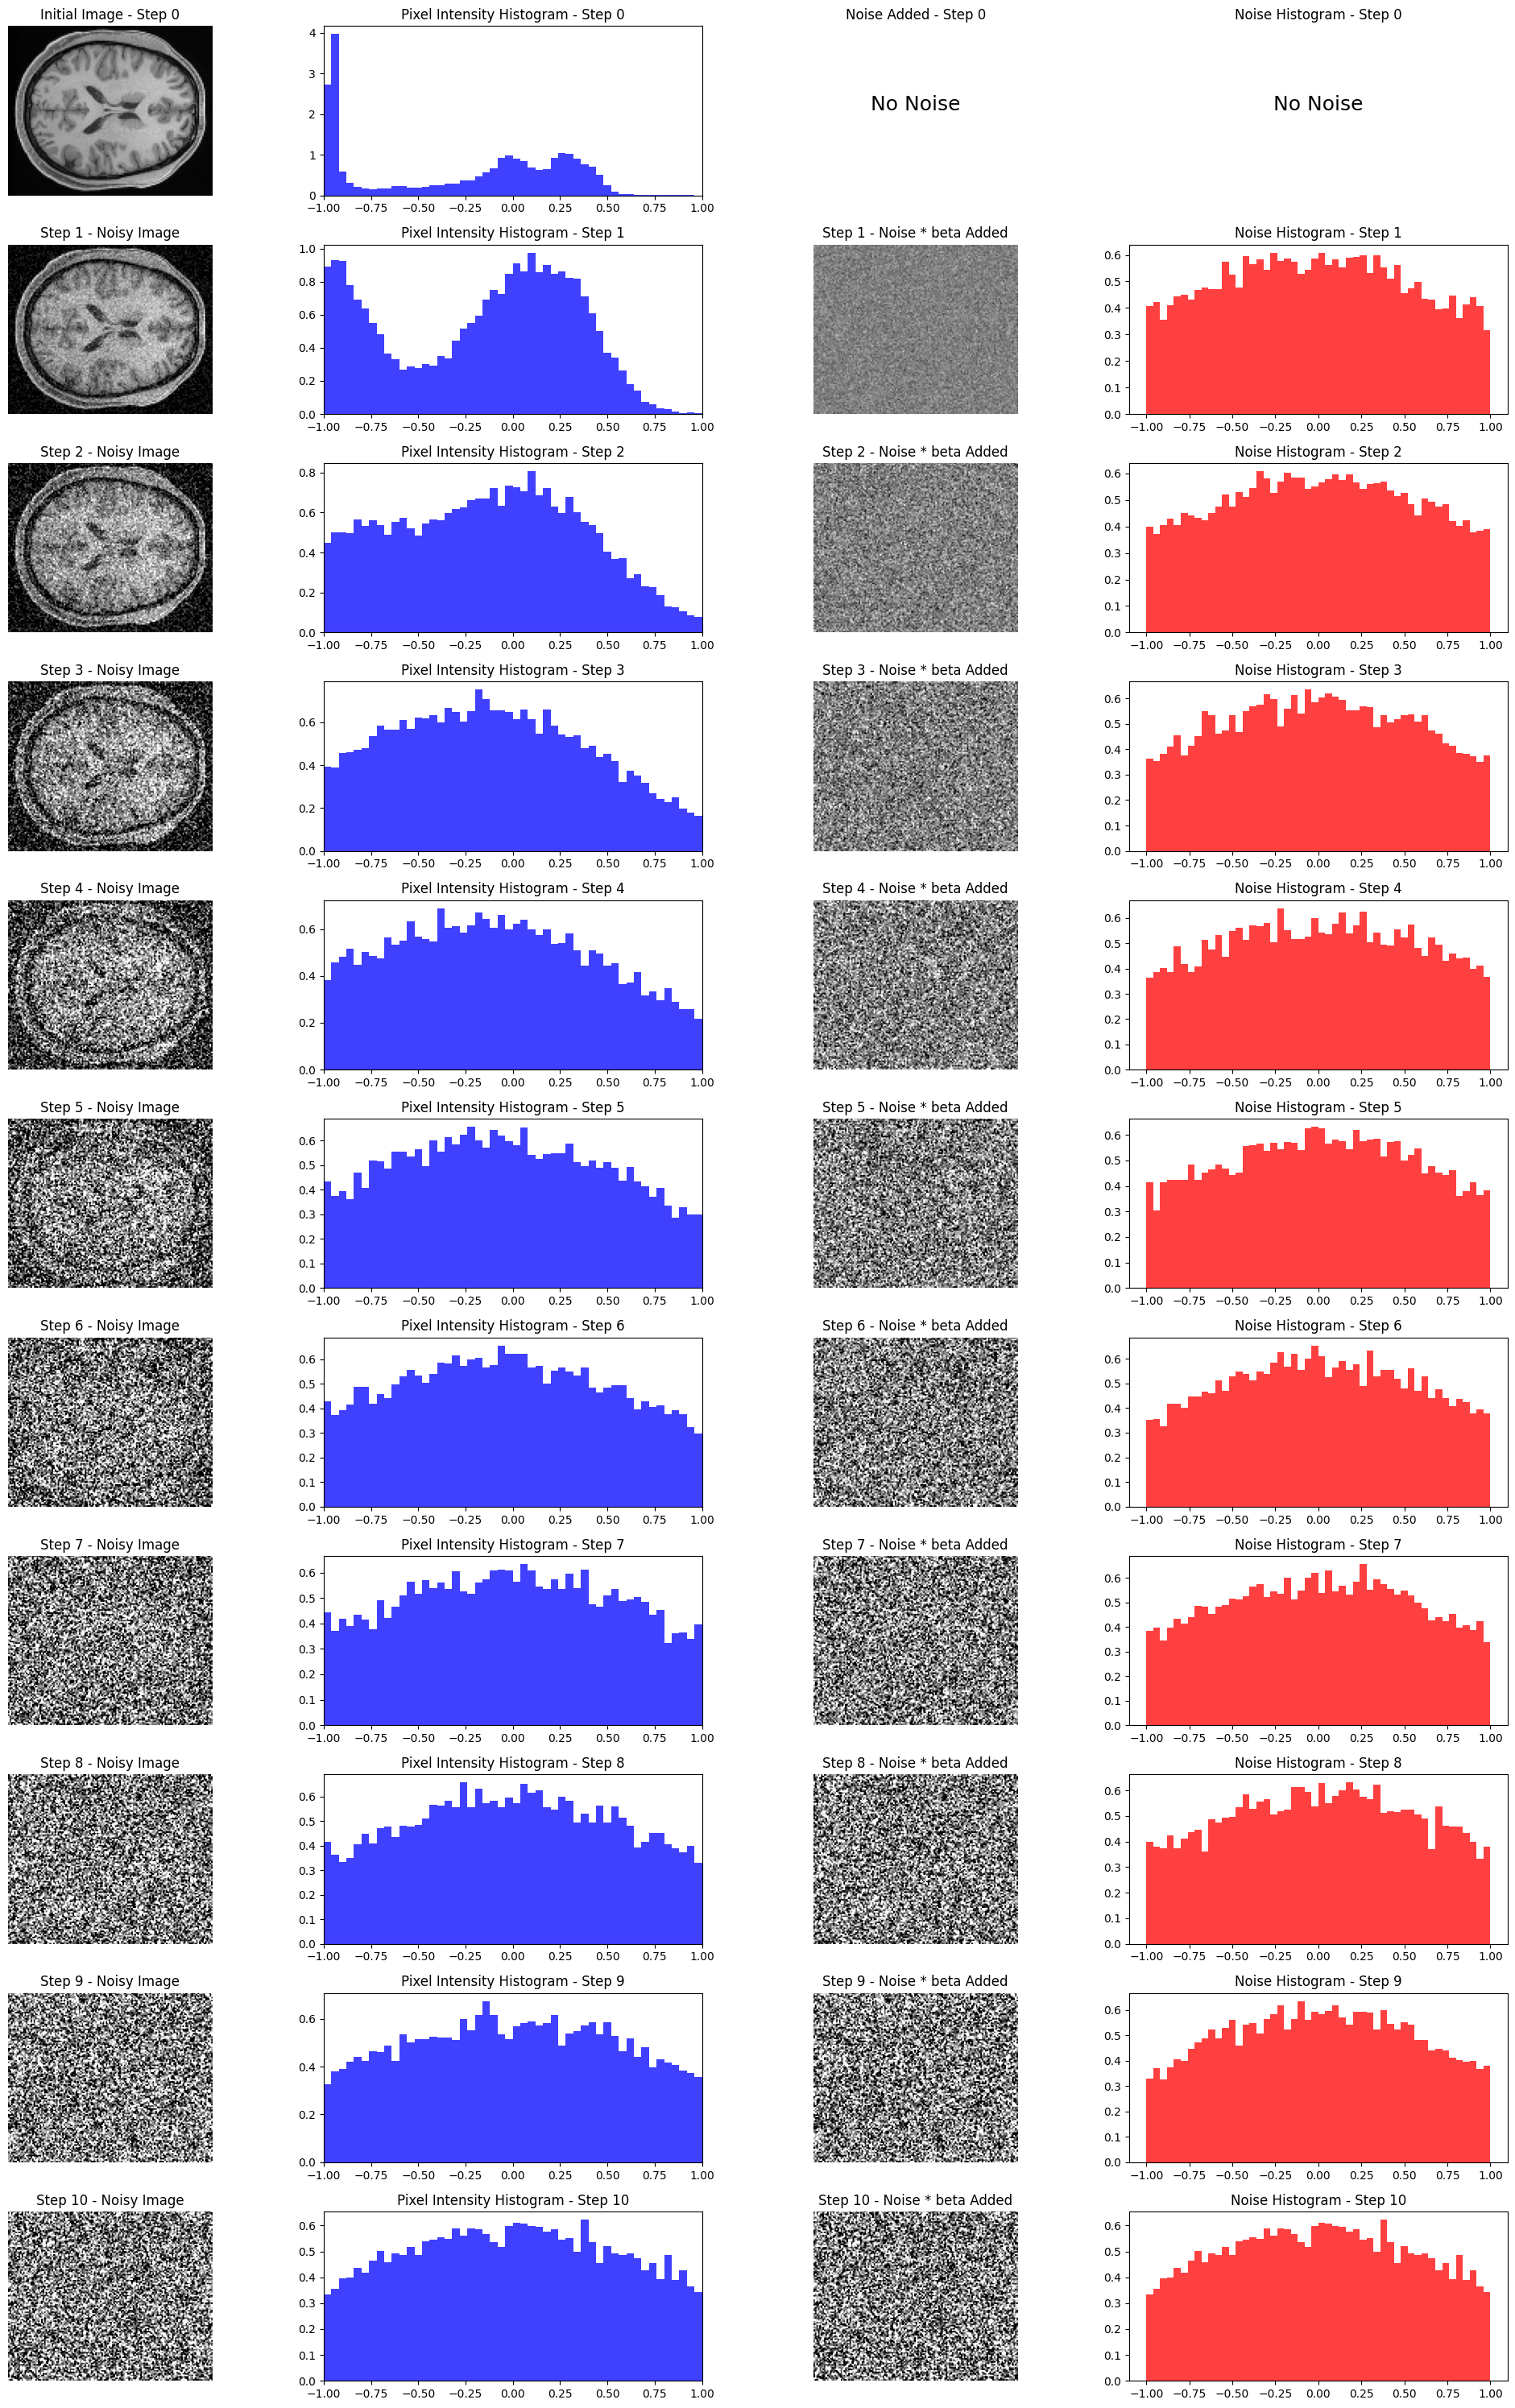

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib


# Load the NIfTI file t1w
nifti_file = '../data/HCP/Structural Preprocessed for 7T (1.6mm:59k mesh)/100610/MNINonLinear/T1w_restore.1.60.nii'
img = nib.load(nifti_file)
data1 = img.get_fdata()
slice_index = data1.shape[2] // 2  # Taking the middle slice along the z-axis
data1 = data1[:, :, slice_index]

#Clip intensity
# data1 = clip_intensity(data1)
#Z normalization
def z_score_normalize(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    z_normalized_data = (data - mean) / std_dev
    return z_normalized_data
data1 = z_score_normalize(data1)
#MinMax to [-1,1]
def min_max_scale(data, new_min=-1, new_max=1):
    data_min = np.min(data)
    data_max = np.max(data)
    data_scaled = (data - data_min) / (data_max - data_min)  # Rescale to [0, 1]
    data_scaled = data_scaled * (new_max - new_min) + new_min  # Rescale to [new_min, new_max]
    return data_scaled
# Assuming data1 and data2 are numpy arrays containing the images
image = min_max_scale(data1)

# Number of steps
num_steps = 10

# Define the linear scheduler for beta
# beta_min = 0.01
# beta_max = 0.4
# betas = np.linspace(beta_min, beta_max, num_steps)

# Define the cosine noise scheduler for alpha
def cosine_schedule(t, T):
    return np.cos((t / T) * np.pi / 2) ** 2
# Compute alpha values using the cosine schedule
alphas = np.array([cosine_schedule(t, num_steps) for t in range(1, num_steps + 1)])
# Compute beta values based on the alpha values
betas = 1 - alphas


# Initialize x_t with the original image
x_t = image

# Plotting the initial image, the progression of noise addition, noise maps, and noise histograms
fig, axes = plt.subplots(num_steps + 1, 4, figsize=(20, 3 * num_steps))

# Print the top-left pixel value of the initial image
print(f"Initial Image - Step 0, Top-Left Pixel Value: {image[0, 0]:.4f}")

# Plot the initial image
axes[0, 0].imshow(image, cmap='gray', vmin=-1, vmax=1)
axes[0, 0].set_title('Initial Image - Step 0')
axes[0, 0].axis('off')

# Plot the histogram of pixel intensities for the initial image
axes[0, 1].hist(image.flatten(), bins=50, range=(-1, 1), density=True, alpha=0.75, color='blue')
axes[0, 1].set_xlim([-1, 1])
axes[0, 1].set_title('Pixel Intensity Histogram - Step 0')

# No noise added for the initial image
axes[0, 2].text(0.5, 0.5, 'No Noise', fontsize=18, ha='center')
axes[0, 2].set_title('Noise Added - Step 0')
axes[0, 2].axis('off')

# No noise histogram for the initial image
axes[0, 3].text(0.5, 0.5, 'No Noise', fontsize=18, ha='center')
axes[0, 3].set_title('Noise Histogram - Step 0')
axes[0, 3].axis('off')

for t in range(1, num_steps + 1):
        
    # Set alpha and beta for the current step
    beta_t = betas[t - 1]
    alpha = np.sqrt(1 - beta_t)
    beta = np.sqrt(beta_t)

    # Generate Gaussian noise with mean 0 and standard deviation 0.2
    noise = np.random.normal(0, 1, image.shape)
    
    # Update x_t using the equation
    x_t = x_t * alpha + beta * noise
    
    # Print the top-left pixel values for the noisy image and the added noise
    print(f"Step {t} - Noisy Image, Top-Left Pixel Value: {x_t[0, 0]:.4f}")
    print(f"Step {t} - Added Noise, Top-Left Pixel Value: {(beta * noise)[0, 0]:.4f}")
    
    # Plot the image at step t
    axes[t, 0].imshow(x_t, cmap='gray', vmin=-1, vmax=1)
    axes[t, 0].set_title(f'Step {t} - Noisy Image')
    axes[t, 0].axis('off')
    
    # Plot the histogram of pixel intensities
    axes[t, 1].hist(x_t.flatten(), bins=50, range=(-1, 1), density=True, alpha=0.75, color='blue')
    axes[t, 1].set_xlim([-1, 1])
    axes[t, 1].set_title(f'Pixel Intensity Histogram - Step {t}')
    
    # Plot the noise map
    axes[t, 2].imshow(noise * beta, cmap='gray', vmin=-1, vmax=1)
    axes[t, 2].set_title(f'Step {t} - Noise * beta Added')
    axes[t, 2].axis('off')

    # Plot the histogram of the noise
    axes[t, 3].hist(noise.flatten(), bins=50, range = (-1,1), density=True, alpha=0.75, color='red')
    axes[t, 3].set_title(f'Noise Histogram - Step {t}')

plt.tight_layout()
plt.show()

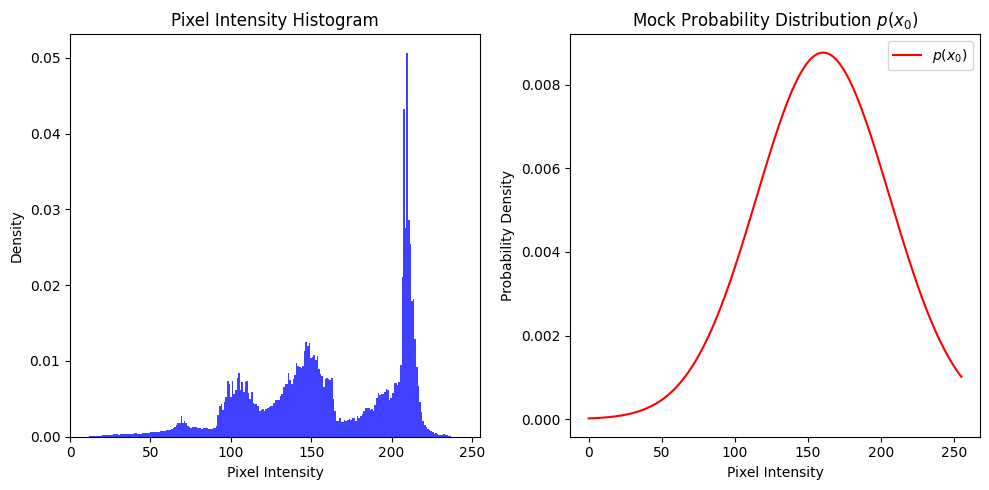

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the image
image_path = 'me.jpg'
image = Image.open(image_path).convert('L')  # Convert to grayscale
image_data = np.array(image)

# Plot the pixel intensity histogram of the image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(image_data.flatten(), bins=256, range=(0, 255), density=True, color='blue', alpha=0.75)
plt.title('Pixel Intensity Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Density')
plt.xlim([0, 255])

# Create a mock probability distribution p(x_0) over pixel intensities
# Assume p(x_0) is a Gaussian distribution centered around the mean intensity
mean_intensity = np.mean(image_data)
std_intensity = np.std(image_data)

pixel_values = np.linspace(0, 255, 256)
mock_p_x0 = (1 / (std_intensity * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((pixel_values - mean_intensity) / std_intensity) ** 2)

# Plot the mock probability distribution p(x_0)
plt.subplot(1, 2, 2)
plt.plot(pixel_values, mock_p_x0, color='red', label=r'$p(x_0)$')
plt.title('Mock Probability Distribution $p(x_0)$')
plt.xlabel('Pixel Intensity')
plt.ylabel('Probability Density')
plt.legend()

plt.tight_layout()
plt.show()

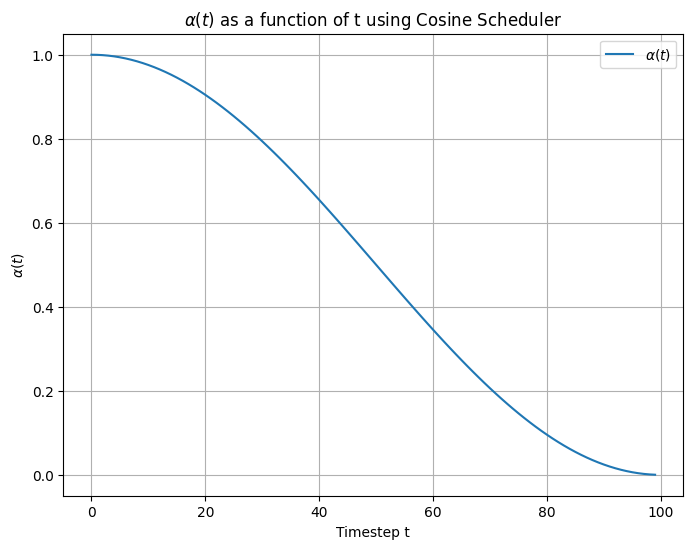

In [114]:
import numpy as np
import matplotlib.pyplot as plt

# Number of steps
num_steps = 100

# Define the cosine noise scheduler for alpha
def cosine_schedule(t, T):
    return np.cos((t / T) * np.pi / 2) ** 2

# Compute alpha values for all timesteps
alphas = np.array([cosine_schedule(t, num_steps) for t in range(num_steps)])

# Plot alpha(t) as a function of t
plt.figure(figsize=(8, 6))
plt.plot(range(num_steps), alphas, label=r'$\alpha(t)$')
plt.xlabel('Timestep t')
plt.ylabel(r'$\alpha(t)$')
plt.title(r'$\alpha(t)$ as a function of t using Cosine Scheduler')
plt.legend()
plt.grid(True)
plt.show()

Initial Image - Step 0, Top-Left Pixel Value: [0.6747967  0.71548116 0.71179044]
Step 1 - Noisy Image, Top-Left Pixel Value: [0.6747967  0.71548116 0.71179044]
Step 1 - Added Noise, Top-Left Pixel Value: [-0.  0.  0.]
Step 2 - Noisy Image, Top-Left Pixel Value: [0.63908963 0.73700244 0.74271119]
Step 2 - Added Noise, Top-Left Pixel Value: [-0.02739921  0.03033004  0.03968407]
Step 3 - Noisy Image, Top-Left Pixel Value: [0.62582791 0.51438621 0.65866723]
Step 3 - Added Noise, Top-Left Pixel Value: [ 0.01801755 -0.18654477 -0.04769309]
Step 4 - Noisy Image, Top-Left Pixel Value: [0.54121602 0.42028762 0.43685656]
Step 4 - Added Noise, Top-Left Pixel Value: [-0.01640073 -0.03803384 -0.15002024]
Step 5 - Noisy Image, Top-Left Pixel Value: [-0.0156192   0.33909038  0.34894037]
Step 5 - Added Noise, Top-Left Pixel Value: [-0.45347216 -0.00092945 -0.00448401]
Step 6 - Noisy Image, Top-Left Pixel Value: [0.20265015 0.09669678 0.06995164]
Step 6 - Added Noise, Top-Left Pixel Value: [ 0.21369459

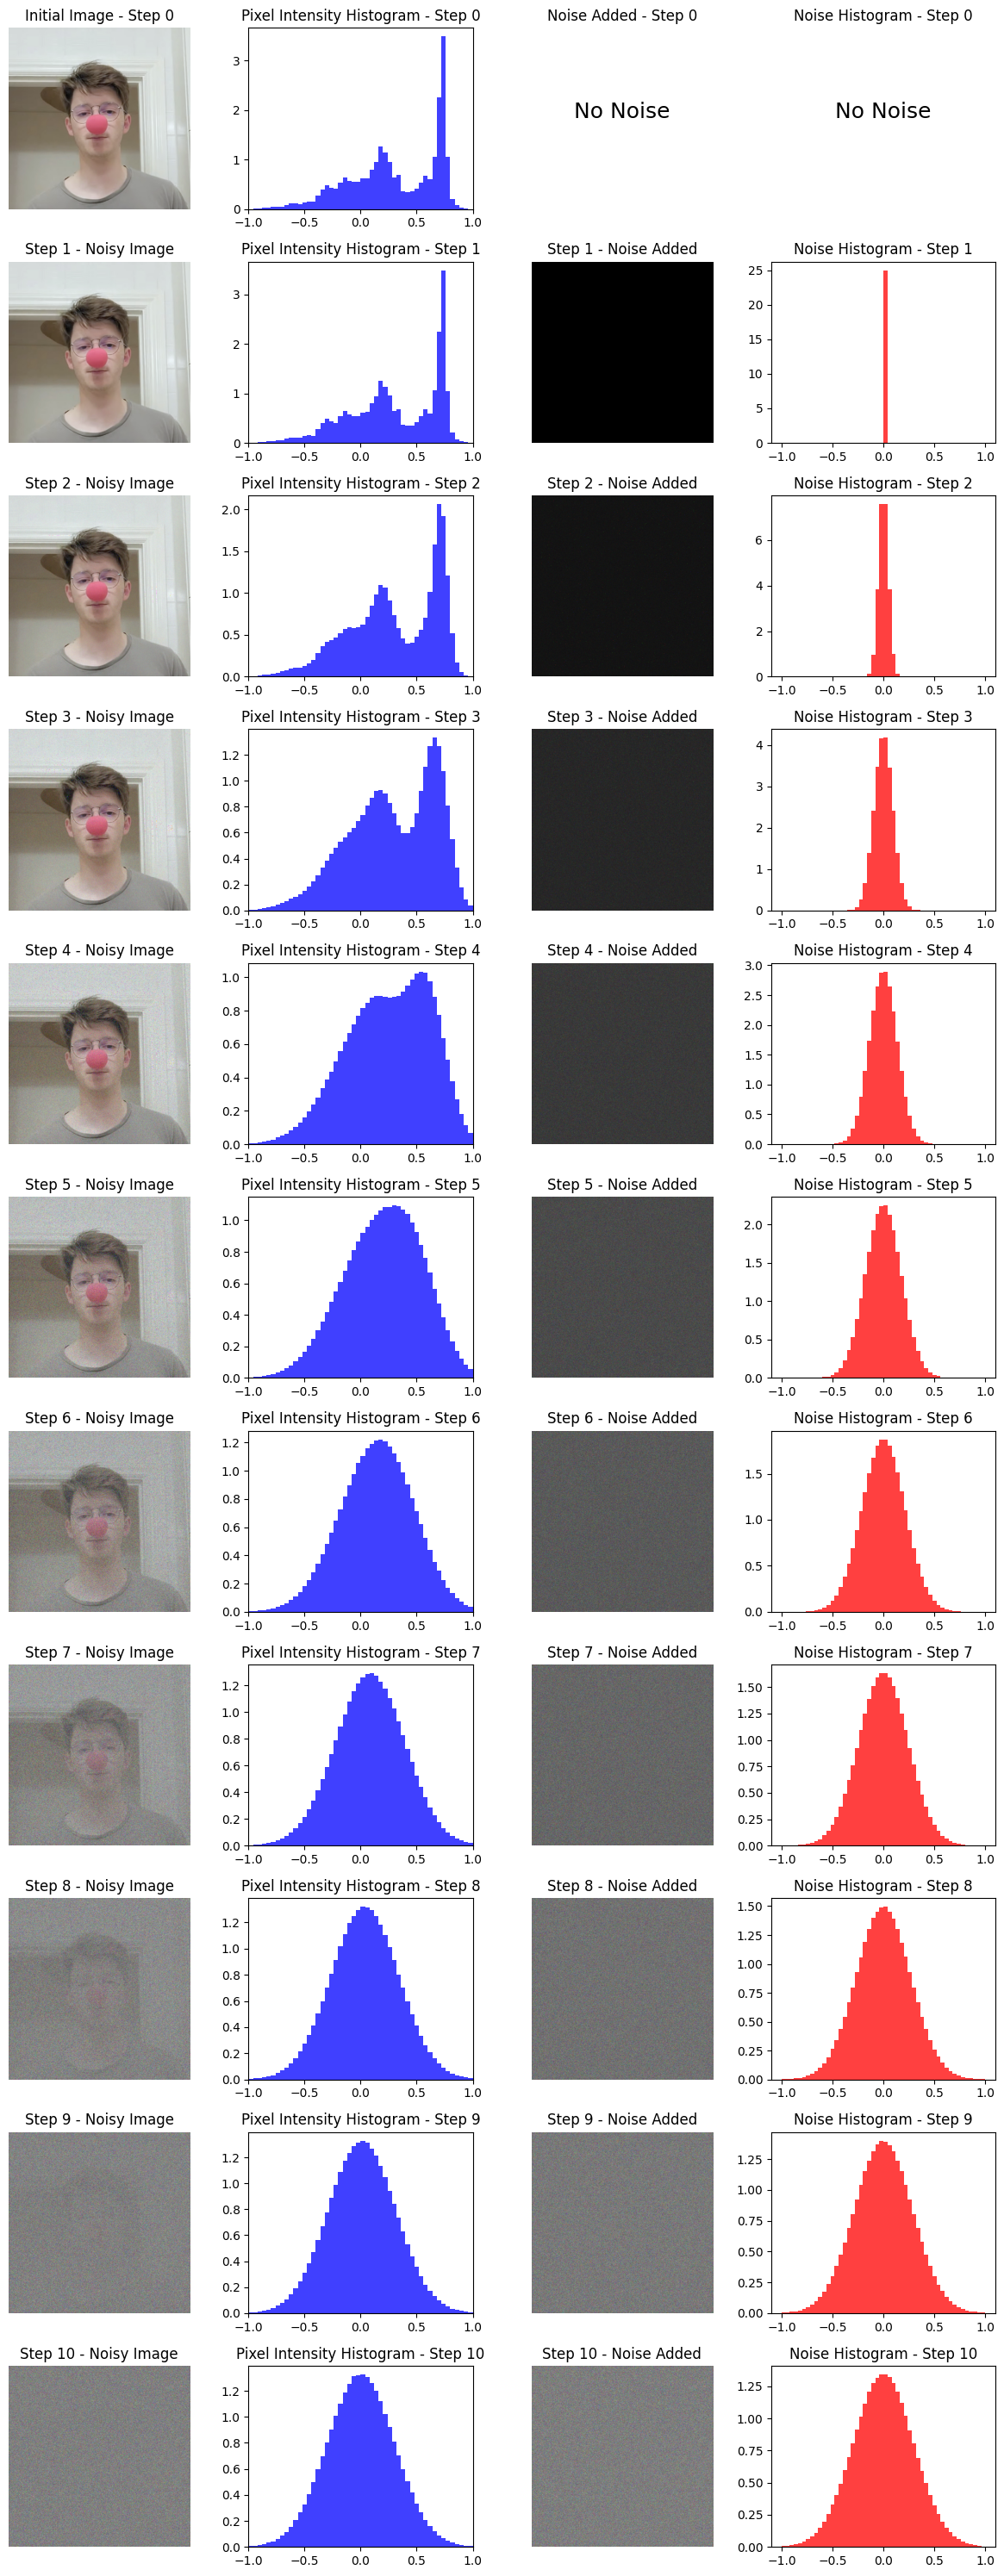

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load and normalize the image
data1 = Image.open('me.jpg')
data1 = np.array(data1, dtype=np.float32)

# Min-Max scaling function to [-1, 1]
def min_max_scale(data, new_min=-1, new_max=1):
    data_min = np.min(data, axis=(0, 1), keepdims=True)  # Calculate min for each channel
    data_max = np.max(data, axis=(0, 1), keepdims=True)  # Calculate max for each channel
    data_scaled = (data - data_min) / (data_max - data_min)  # Rescale to [0, 1]
    data_scaled = data_scaled * (new_max - new_min) + new_min  # Rescale to [new_min, new_max]
    return data_scaled

# Apply Min-Max scaling to [-1, 1]
image = min_max_scale(data1)

# Number of steps
num_steps = 10

# Define the cosine noise scheduler for alpha and beta
def cosine_schedule(t, T):
    return np.cos((t / T) * np.pi / 2) ** 2

alphas = np.array([cosine_schedule(t, num_steps) for t in range(num_steps)])
betas = 1 - alphas

# Initialize x_t with the original image
x_t = image

# Plotting the initial image, the progression of noise addition, noise maps, and noise histograms
fig, axes = plt.subplots(num_steps + 1, 4, figsize=(12, 3 * num_steps))

# Print the top-left pixel value of the initial image
print(f"Initial Image - Step 0, Top-Left Pixel Value: {image[0, 0]}")

# Convert the initial image to the range [0, 255] for display
image_display = ((image + 1) / 2 * 255).astype(np.uint8)

# Plot the initial image
axes[0, 0].imshow(image_display)
axes[0, 0].set_title('Initial Image - Step 0')
axes[0, 0].axis('off')

# Plot the histogram of pixel intensities for the initial image
axes[0, 1].hist(image.flatten(), bins=50, range=(-1, 1), density=True, alpha=0.75, color='blue')
axes[0, 1].set_xlim([-1, 1])
axes[0, 1].set_title('Pixel Intensity Histogram - Step 0')

# No noise added for the initial image
axes[0, 2].text(0.5, 0.5, 'No Noise', fontsize=18, ha='center')
axes[0, 2].set_title('Noise Added - Step 0')
axes[0, 2].axis('off')

# No noise histogram for the initial image
axes[0, 3].text(0.5, 0.5, 'No Noise', fontsize=18, ha='center')
axes[0, 3].set_title('Noise Histogram - Step 0')
axes[0, 3].axis('off')

for t in range(1, num_steps + 1):
    # Set alpha and beta for the current step
    alpha = np.sqrt(alphas[t - 1])
    beta = np.sqrt(betas[t - 1])

    # Generate Gaussian noise with mean 0 and standard deviation 0.3
    noise = np.random.normal(0, 0.3, image.shape)
    
    # Update x_t using the equation
    x_t = x_t * alpha + beta * noise
    
    # Print the top-left pixel values for the noisy image and the added noise
    print(f"Step {t} - Noisy Image, Top-Left Pixel Value: {x_t[0, 0]}")
    print(f"Step {t} - Added Noise, Top-Left Pixel Value: {(beta * noise)[0, 0]}")
    
    # Convert the image to the range [0, 255] for display
    image_display = ((x_t + 1) / 2 * 255).astype(np.uint8)
    
    # Plot the image at step t
    axes[t, 0].imshow(image_display)
    axes[t, 0].set_title(f'Step {t} - Noisy Image')
    axes[t, 0].axis('off')
    
    # Plot the histogram of pixel intensities
    axes[t, 1].hist(x_t.flatten(), bins=50, range=(-1, 1), density=True, alpha=0.75, color='blue')
    axes[t, 1].set_xlim([-1, 1])
    axes[t, 1].set_title(f'Pixel Intensity Histogram - Step {t}')
    
    # Plot the noise map in RGB
    noise_display = (((noise + 1) / 2 * 255)*beta).astype(np.uint8)  # Scale noise to [0, 255] for display
    axes[t, 2].imshow(noise_display)
    axes[t, 2].set_title(f'Step {t} - Noise Added')
    axes[t, 2].axis('off')

    # Plot the histogram of the noise
    axes[t, 3].hist(noise.flatten() * beta, bins=50, range=(-1, 1), density=True, alpha=0.75, color='red')
    axes[t, 3].set_title(f'Noise Histogram - Step {t}')

plt.tight_layout()
plt.show()

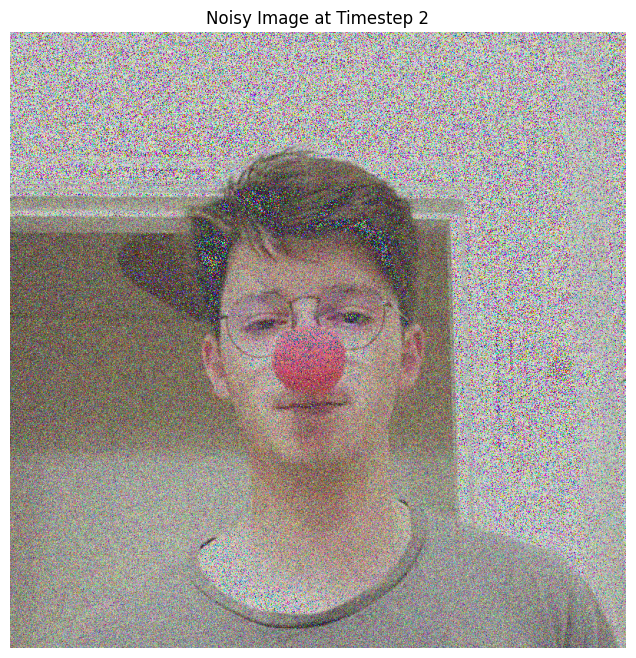

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load and normalize the image
data1 = Image.open('me.jpg')
data1 = np.array(data1, dtype=np.float32)

# Min-Max scaling function to [-1, 1]
def min_max_scale(data, new_min=-1, new_max=1):
    data_min = np.min(data, axis=(0, 1), keepdims=True)  # Calculate min for each channel
    data_max = np.max(data, axis=(0, 1), keepdims=True)  # Calculate max for each channel
    data_scaled = (data - data_min) / (data_max - data_min)  # Rescale to [0, 1]
    data_scaled = data_scaled * (new_max - new_min) + new_min  # Rescale to [new_min, new_max]
    return data_scaled

# Apply Min-Max scaling to [-1, 1]
image = min_max_scale(data1)

# Define the linear scheduler for beta
num_steps = 10
beta_min = 0.01
beta_max = 0.2
betas = np.linspace(beta_min, beta_max, num_steps)
alphas = 1 - betas
alpha_cum_prod = np.cumprod(alphas)

# Choose the timestep t
t = 2  # Change this to the specific timestep you want to visualize

# Compute the cumulative alpha product for timestep t
sqrt_alpha_cum_prod_t = np.sqrt(alpha_cum_prod[t])

# Generate Gaussian noise
noise = np.random.normal(0, 1, image.shape)

# Compute the noisy image at timestep t using the reparameterization trick
x_t = sqrt_alpha_cum_prod_t * image + np.sqrt(1 - alpha_cum_prod[t]) * noise

# Convert the image to the range [0, 255] for display
image_display = ((x_t + 1) / 2 * 255).astype(np.uint8)

# Plot the image at timestep t
plt.figure(figsize=(8, 8))
plt.imshow(image_display)
plt.title(f'Noisy Image at Timestep {t}')
plt.axis('off')
plt.show()